## Predicción de precio de Aguacates en California

*Holy Guacamole!* Si habeis viajado alguna vez a la costa oeste de EEUU y comprado aguacate en los últimos años, seguramente os sorprendería lo caro que era. Lo que comenzó como una moda en California, ha conquistado medio mundo y algunas personas han terminado hablando de un "apocalysis de aguacates" ([avocado apocalypse](https://www.smithsonianmag.com/science-nature/holy-guacamole-how-hass-avocado-conquered-world-180964250/)).

Bromas aparte, encontramos este dataset de datos de stock de aguacates en las diferentes regiones de EEUU desde 2015 hasta 2019 y nos pareció interesante analizarlo como parte de nuestro estudio de series temporales

Nuestro objetivo es identificar y predecir sintomatologías de el precio del aguacate en California. Además queremos responder las siguientes preguntas:

* ¿Cómo ha evolucionado el precio medio del aguacate en las ciudades más importantes de la Costa Oeste?
* ¿Cómo ha evolucionado el precio medio del aguacate en California?
* ¿Podemos identificar patrones a lo largo del tiempo (estacionalidad, correlación, etc)? 
* ¿Podemos identificar el precio del aguacate en California a 3 meses vista?

## 1. Preparando los datos

Antes de empezar, resaltar algunas cosas importantes de nuestros datos:

* No tienen missing values :D
* **No tiene fechas organizadas** (empiezan a finales de 2015, retroceden durante todo 2015, luego 2016, y así sucesivamente) Por ello, tuvimos que organizar las fechas al definir el índice
* El campo `types` tiene las categorías `organic` y `conventional`. Vimos que existíanmuchísimos más muestras para los aguacates corrientes, así que para facilitar el analisis, nos centraremos sólo en los `conventional`
* En el campo región, existe el campo `California` pero no el campo `Oregon`. Así que no podemos analizar toda la costa oeste estadounidense como nos gustaría (nos centraremos en California)

In [1]:
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="mostrar/ocultar código."></form>''')


In [6]:
df = pd.read_csv('avocado.csv', index_col=0)
#Podemos ver que el campo fecha esta como tipo object.
#Por ello, lo convertimos a tipo fecha con la función de pandas.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df= df.sort_index()

Hagamos una visualización rápida a la evolución del preco por regiones. La sigueinte gráfica interactiv, permite identificar de forma general similitudes, tendencias y evolución en el precio de [las 5 ciudades más pobladas de la costa oeste](https://en.wikipedia.org/wiki/List_of_largest_cities_on_the_United_States_West_Coast). Además podremos filtrar por rangos de tres años, un año, medio mes, tres meses y 30 días para inpecionar patrones con mayor facilidad.

In [7]:
LA = df[(df.region=='LosAngeles')&(df.type == 'conventional')]
San_Diego = df[(df.region=='SanDiego')&(df.type == 'conventional')]
San_Francisco = df[(df.region=='SanFrancisco')&(df.type == 'conventional')]
Seattle = df[(df.region=='Seattle')&(df.type == 'conventional')]
Portland = df[(df.region=='Portland')&(df.type == 'conventional')]

#Total = df[(df.region == 'TotalUS')&(df.type == 'conventional')]

In [8]:
trace0 = go.Scatter(x=LA.index, y=LA.AveragePrice, name='L.A')
trace1 = go.Scatter(x=San_Diego.index, y=San_Diego.AveragePrice, name='San Diego')
trace2 = go.Scatter(x=San_Francisco.index, y=San_Francisco.AveragePrice, name='San Francisco')
trace3 = go.Scatter(x=Seattle.index, y=Seattle.AveragePrice, name='Seattle')
trace4 = go.Scatter(x=Portland.index, y=Portland.AveragePrice, name='Portland')

data = [trace0, trace1, trace2, trace3, trace4]

In [9]:
# todo lo que no este relacionado con los datos se pone en una nueva
# variable layout en forma diccionario

layout = dict(
    title='Precios Aguacates desde 2015 a 2018',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=3,
                     label='3m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='12m',
                     step='month',
                     stepmode='backward'
                    )
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

Si ignoramos San Francisco, el resto de ciudades han permanecido en rangos estables en 2015 y gran parte del 2016. Es a partir de finales de este cuando los precios empiezan a tener pronunciados picos y valles.

>NOTA: Si hacemos click en una determinada region, podemos eliminarla de la gráfica interactiva para ver mejor la evolución en cada una de las ciudades

In [10]:
Cali = df[(df.region=='California')&(df.type == 'conventional')]
data2 = go.Scatter(x=Cali.index, y=Cali.AveragePrice, name='California')

In [11]:
layout = dict(
    title='Precios Aguacates en California desde 2015 a 2018',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=3,
                     label='3m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='12m',
                     step='month',
                     stepmode='backward'
                    )
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data2, layout=layout)
py.iplot(fig)

## 2. Diagnóstico previo

Antes de empezar a trabajar con nuestros modelos, debemos de asegurarnos de algunos conceptos clave para saber qué modelo puedes ser el más indicado para probar y bajo qué parámetros nuestra predicción puede ser más certera. En concreto, analizaremos los siguientes puntos:

* Estacionariedad
* Correlación absoluta
* Correlación parcial

### ¿Son mis datos estacionarios? ADF

Antes de aplicar modelos queremos dar evidencia de si nuestros datos son o no estacionarios. Para ello, nos basamos en el [test ADF](https://es.wikipedia.org/wiki/Prueba_de_Dickey-Fuller_aumentada). Este elimina las autocorrelaciones para identificar de manera más precisa si nuestros datos son o no estacionarios

La hipótesis nula (H0) de la prueba es que la serie de tiempo puede ser representada por una raíz unitaria, que no es estacionaria. La hipótesis alternativa (H1) (rechazando la hipótesis nula) es que la serie temporal es estacionaria.

Un valor p por debajo de un umbral (que nosotros establecemos al 5%) significa que podemos rechazar la hipótesis nula (estacionaria). Por otro lado, un valor p por encima del umbral significa que no podemos rechazar la hipótesis nula (no estacionaria)y por lo tanto, el probable que la serie necesite ser deiferenciada.

* Valor p> 0.05: No se puede rechazar la hipótesis nula (H0), los datos tienen una raíz unitaria y no son estacionarios.

* Valor p <= 0.05: Rechaza la hipótesis nula (H0), los datos no tienen una raíz unitaria y son estacionarios.

In [12]:
stl_cali = Cali.drop(columns = ['Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year','region'])

In [13]:
from statsmodels.tsa.stattools import adfuller

X = stl_cali.values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.204547
p-value: 0.019723
	1%: -3.470
	5%: -2.879
	10%: -2.576


Tras relizar el test con la función `adfuller()`sacamos un valor p<=0.05 Esto sugiere que podemos rechazar la hipótesis nula con un umbral de menos del 5% (es decir, una baja probabilidad de que el resultado sea una casualidad estadística).

Por lo tanto, según la prueba de Dicker Fuller, **es probable que nuestros datos presenten estacionariedad**. Es decir, que a lo largo de la serie, su media y varianza se mantengan más o menos constantes a lo largo del tiempo.

Esto es bastante importante para luego aplicar modelos, ya que si asumimos que son estacionarios, tendremos que indicar que nuestra serie es `I(0)` y no hay que aplicar diferenciación (la serie se denominaría como I(1))

### ¿Cómo de correlados están nuestros datos?

Una vez hemos comprobado que no es necesaria una diferenciación en nuestra serie, es hora de analizar la correlación absoluta y parcial. Esto nos permitirá identificar los campos más óptimos para AR (p) y MA (q). 

Saber esto nos ayudará a la hora de definir los modelos que aplicaremos a nuestra serie, como el modelo ARIMA

**Correlación absoluta**

La función de autocorrelación (ACF) puede indicarnos la fuerza de una relación con una observación en una serie de tiempo con observaciones en pasos de tiempo anteriores mediante una función discreta que muestra la correlación entre lags de tiempo.

Si quisieramos aplicar modelos de autoregresión (AR) nos permitirá saber cual es el valor óptimo de p (tiempos previos de los que depende nuestro tiempo actual).

A primera vista, parece que nuesto valor óptimo de p sería 6 lags. Sin embargo, cabe la posibilidad de que las autocorrelaciones de los lags 1-2 y superiores se deban simplemente a la propagación de la autocorrelación en el lag 1. Podemos confirmar esto mostrando una gráfica PACF.

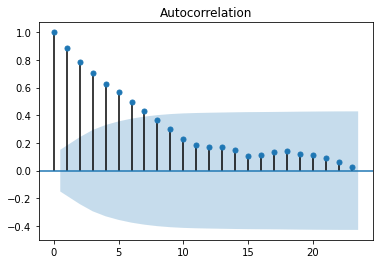

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
plot_acf(stl_cali)
pyplot.show()

# valor óptimo de p entre 1y2

Por defecto, `plot_acf()` muestra un intervalo de confianza del 95% (área azul) hasta un lag de 20 tiempos.

**Correlación parcial**

También podemos calcular la función de autocorrelación parcial (PACF). Si quesieramos aplicar modelos de media móvil (MA) o modelos autoregresivos de media móvil (ARMA), esto nos permitiría ver el punto óptimo para q.

En este caso, vemos que un buen valor de q estará ente 0 y 1 lag

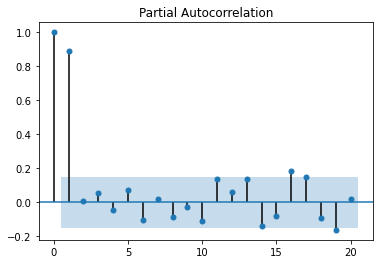

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(stl_cali, lags=20)
pyplot.show()

# valor de q es 0 ó 1

## 3. Modelos de predicción

Las tres principales librerías que utilizaremos serán [DARTS](https://unit8co.github.io/darts/index.html), [fbprophet](https://facebook.github.io/prophet/) y Statsmodels.

En primer lugar, dividimos nuestros datos train (hasta enero del 2018) y validacion (hasta marzo del 2018).
Seguidamente, y aprovechando la facilidad de DARTS en probar modelos, hacemos una evaluación de los modelos más usados en series temporales centrándonos en el error medio de porcentaje absoluto (MAPE) como métrica

In [16]:
from darts import TimeSeries

darts_cali = stl_cali.reset_index()

series = TimeSeries.from_dataframe(darts_cali, 'Date', 'AveragePrice')
train, val = series.split_after(pd.Timestamp('20180101'))

In [17]:
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT
)
from darts.metrics import mape, mase
from darts.backtesting import (
    backtest_forecasting,
    backtest_regression,
    plot_residuals_analysis,
    forecasting_residuals
)
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [18]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('el modelo {} tiene un MAPE de: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(Prophet())
eval_model(ExponentialSmoothing())
eval_model(AutoARIMA())
eval_model(ARIMA())
eval_model(ARIMA(6,0,1))
eval_model(ARIMA(1,0,1))
eval_model(ARIMA(1,0,0))

el modelo Prophet tiene un MAPE de: 19.13%
el modelo Exponential smoothing tiene un MAPE de: 17.01%
el modelo Auto-ARIMA tiene un MAPE de: 13.20%
el modelo ARIMA(12,1,0) tiene un MAPE de: 11.31%
el modelo ARIMA(6,0,1) tiene un MAPE de: 10.89%
el modelo ARIMA(1,0,1) tiene un MAPE de: 10.74%
el modelo ARIMA(1,0,0) tiene un MAPE de: 10.58%


Vemos que, a primera vista y sin tocar parámetros (por defecto, (12,1,0), el modelo ARIMA ya consigue un buen resultado (MAPE de 11.31%). Sin embargo, aplicando los parámetros que habíamos sacado previamente, nuestro ARIMA de orden (1, 0, 0), es decir, un AR(1) parece ser el más apropiado, con un error medio de porcentaje absoluto del 10.58%. 

Además, también probamos con ARIMA de orden (6,0,1) (para ver efectivamente, las autocorrelaciones de los lags que vimos anteriormente en la funcion ACF se debían a la propagación de la autocorrelación en el lag 1) además de ARIMA (1,0,1) ó ARMA, ya que el valor de q rondaba entre el valor 0 y 1.

Por otro lado, el modelo con los resultados más pobres, parece ser prophet (MAPE de 19.13%). Prophet es un modelo de regresión aditiva con cuatro componentes principales, en las que podemos incluir el factor vacacional (holidays) que en este caso no hemos establecido. Funciona bastante bien para los cambios de tendencia, y suele ser más eficaz con datos temporales no estacionarios.

Veamos más en detalle el modelo ganador: **AR(1)**

## Predicción con ARIMA (1, 0, 0)

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
arima_cali = ARIMA(stl_cali, order=(1,0,0))

In [21]:
model_fit = arima_cali.fit()

In [22]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:           AveragePrice   No. Observations:                  169
Model:                     ARMA(1, 0)   Log Likelihood                 138.718
Method:                       css-mle   S.D. of innovations              0.106
Date:                Wed, 15 Jul 2020   AIC                           -271.436
Time:                        22:49:31   BIC                           -262.047
Sample:                    01-04-2015   HQIC                          -267.626
                         - 03-25-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0956      0.067     16.387      0.000       0.965       1.227
ar.L1.AveragePrice     0.8830      0.035     25.313      0.000       0.815       0.951
                    

**Tendencia del error de los residuos**

Veamos los resultados con más detalle. En primer lugar, mostrando los residuos podemos ver como la tendencia del error es constante, lo cual es un buen indicador

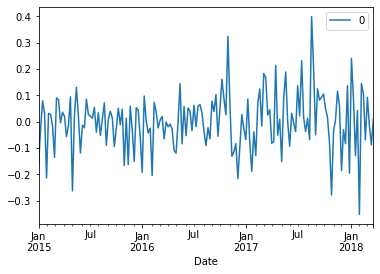

In [23]:
from pandas import DataFrame
residuls = DataFrame(model_fit.resid)
residuls.plot()

# La tendencia de los residuos de error es constante, eso es bueno

**Autocorrelación de residuos**

A continuación, realizamos un plot de la autocorrelación de los residuos, para corroborar que lo que tenemos es ruido blanco y no existe más extructura que identificar. En el mejor escenario, no esperaríamos que haya ninguna correlación entre los residuos. Esto se mostraría si los valores de autocorrelación estuvieran por debajo del umbral de significancia (líneas horizontales discontinuas que aparecen en la gráfica).

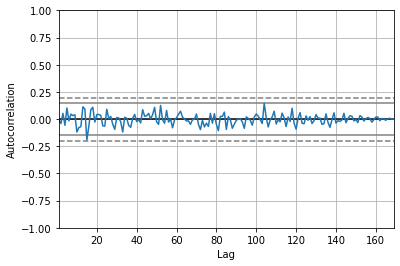

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(residuls)
pyplot.show()

**Distribución de residuos**

Al hacer un plot de la distribución de nuestros residuos, vemos que nuestros datos se acercan a una distribución normal. Otro buen indicador para nuestro modelo. 

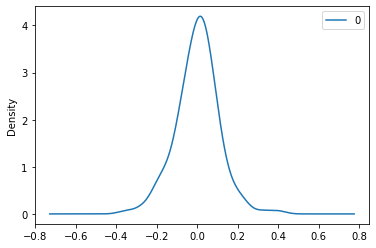

In [25]:
residuls.plot(kind='kde')
# para saber si los datos estas distribuidos de forma normal

**Media de los residuos**

Al mostrar sus estadísticos y como ya habíamos intuido en la anterior gráfica, la media es muy cercana de 0.

In [26]:
residuls.describe()
# media muy cercana a 0, eso es bueno

0
count  169.000000
mean     0.000865
std      0.106917
min     -0.352462
25%     -0.057142
50%      0.009236
75%      0.058933
max      0.399236

De forma general, nuestro modelo AR(1) se podría adecuar bien para predecir el precio de los aguacates en California a 3 meses vista.